In [4]:
from models.classifier import model
from models.cnn_md import cnn_md

In [2]:
import torch
import numpy as np
from docopt import docopt
from models.classifier import model
from preprocessing.dataset import Dataset2Channels, Dataset1Channel
from utils.constants import MAPPING_LABELS_DICT, MAPPING_LYING_LABELS
from datetime import datetime
from torchvision import transforms
from utils.torch import ToTensor4D

/home/aidin/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/aidin/anaconda3/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [41]:
import os

TYPE = 'mDoppler'

mode = 'standing'
aggregate = True
train_data = 'train_mDoppler_2channels_standing.h5'

test_data ='test_mDoppler_2channels_standing.h5'


if mode == 'lying':
        labels_transform = np.vectorize(
            lambda label: MAPPING_LYING_LABELS[label]
        )
elif aggregate:
    labels_transform = np.vectorize(
        lambda label: MAPPING_LABELS_DICT[label]
    )
else:
    labels_transform = None

if TYPE == 'mDoppler':
    features_transform = transforms.Compose([
        #lambda x: x[:, :, 9:-9],
        transforms.ToTensor(),
        transforms.Normalize((0,), (1,))
    ])
else:
    features_transform = transforms.Compose([
        ToTensor4D(),
        transforms.Normalize((0,), (1,))
    ])

train_data = Dataset2Channels(
    TYPE=TYPE,
    dirname='DATA_preprocessed',
    filename=train_data,
    features_transform=features_transform,
    labels_transform=labels_transform,
    combine_channels=True
)

test_data = Dataset2Channels(
    TYPE=TYPE,
    dirname='DATA_preprocessed',
    filename=test_data,
    features_transform=features_transform,
    labels_transform=labels_transform,
    combine_channels=True
)

in_channels = 2

# shuffle data
train_data.shuffle()
test_data.shuffle()


if labels_transform is not None:
    num_classes = len(np.unique(labels_transform(train_data.labels[:])))
else:
    num_classes = len(np.unique(train_data.labels[:]))

# load model
model_name = 'CNN-MD'

In [51]:
import torch
import matplotlib.pyplot as plt

def plot_features(model, input_data):
    # Set the model to evaluation mode
    model.eval()

    # Get the feature maps from the convolutional layers
    feature_maps = []
    hooks = []

    def hook_fn(module, input, output):
        feature_maps.append(output.detach())

    # Register the hook to each convolutional layer
    for module in model.cnn.modules():
        if isinstance(module, torch.nn.Conv2d):
            hooks.append(module.register_forward_hook(hook_fn))

    # Forward pass to generate the feature maps
    model(input_data)

    # Unregister the hooks
    for hook in hooks:
        hook.remove()

    # Plot the feature maps
    num_layers = len(feature_maps)
    fig, axs = plt.subplots(1, num_layers, figsize=(20, 15))

    for i, fmap in enumerate(feature_maps):
        fmap = fmap.squeeze(0)  # Remove the batch dimension
        num_channels = fmap.size(0)
        axs[i].imshow(torch.sum(fmap, dim=0), cmap='gray')
        axs[i].set_title(f'Layer {i+1}\nChannels: {num_channels}')

    plt.tight_layout()
    plt.show()


In [45]:
# Create the model object
classifier = model(
    train_data=train_data,
    test_data=test_data,
    case=3,
    model_type=model_name,
    device='cpu',
)

dropout = 0.2

classifier.create_model(
    in_channels=in_channels,
    num_classes=num_classes,
    dropout=dropout,
)

In [46]:
load = 'CNN-MD__0.695__20230611'

if load != "None":
    print(f'Loading model {load}')
    classifier.load_model(
        name=load,
    )

In [47]:
batch_size=64
classifier.create_DataLoaders(
    batch_size=batch_size,
    #num_workers=1
)

In [48]:
classifier.summary(
    save=True,
    name=f'{model_name}_case{3}_summary.txt'
)

In [49]:
classifier.model.eval()

cnn_md(
  (cnn): Sequential(
    (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ELU(alpha=1.0)
    (6): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ELU(alpha=1.0)
    (10): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.2, inplace=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ELU(alpha=1.0)
    (14): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=1536

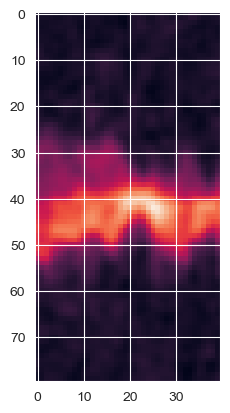

In [57]:
plt.imshow(train_data[100][0][0])

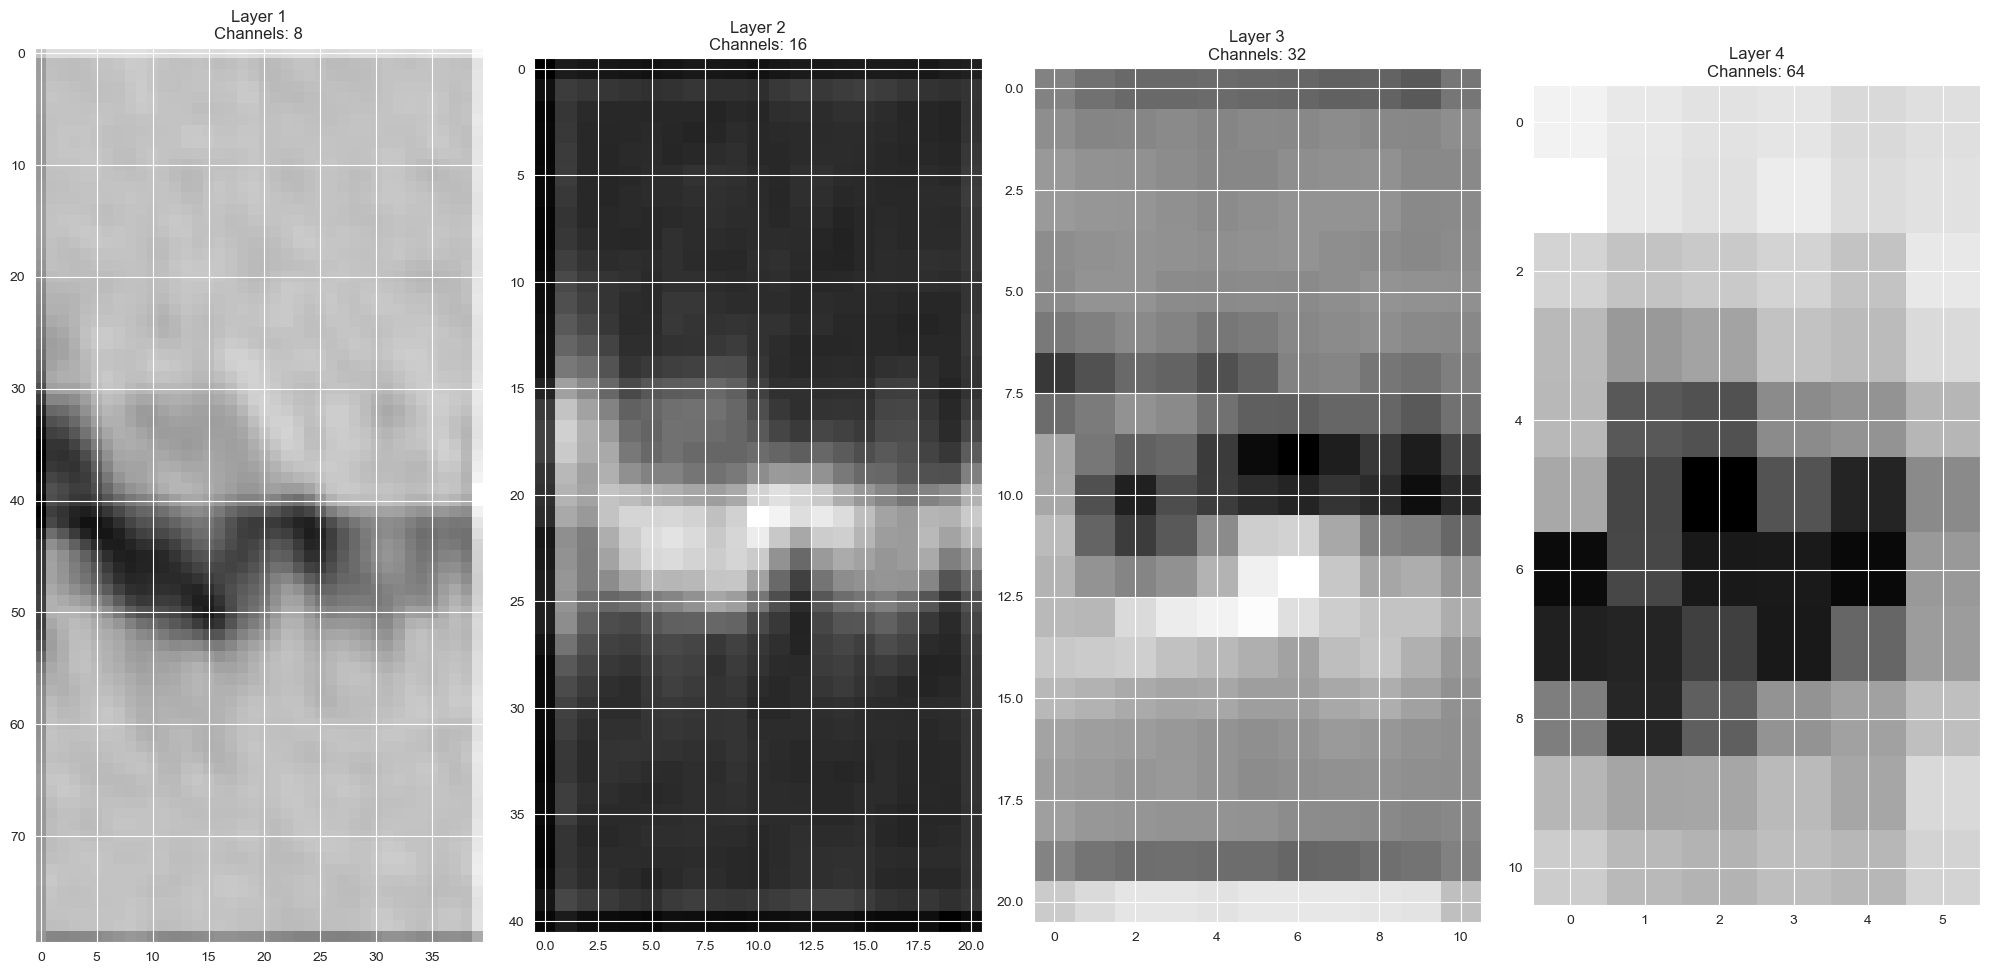

In [59]:
plot_features(classifier.model, train_data[100][0].unsqueeze(0))

In [ ]:
# load model
model_name = 'CNN-MD'

# Create the model object
classifier = model(
    train_data=train_data,
    test_data=test_data,
    case=3,
    model_type=model_name,
    device='cpu',
)

dropout = 0.2

classifier.create_model(
    in_channels=in_channels,
    num_classes=num_classes,
    dropout=dropout,
)

load = 'ResNet18__0.696__20230610_SAVED'

if load != "None":
    print(f'Loading model {load}')
    classifier.load_model(
        name=load,
    )

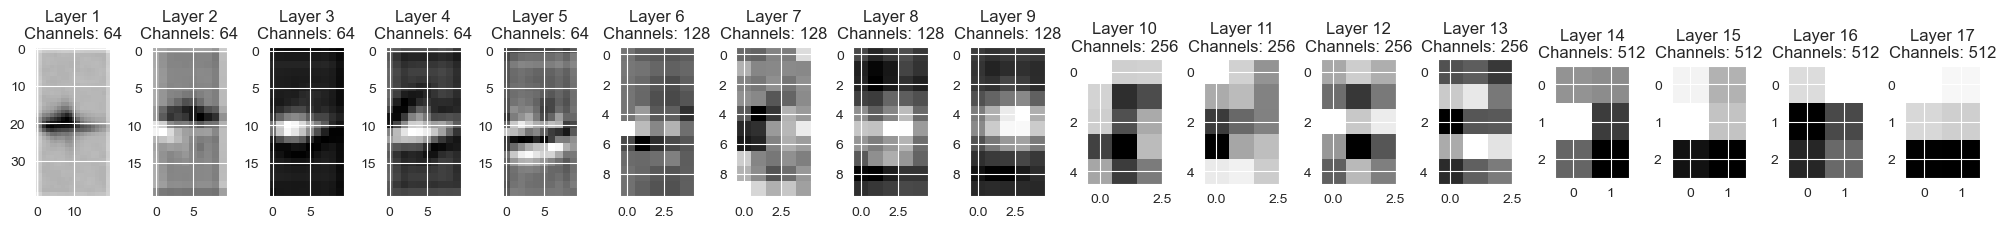

In [39]:
import torch
import matplotlib.pyplot as plt

def plot_features(model, input_data):
    # Set the model to evaluation mode
    model.eval()

    # Get the feature maps from the convolutional layers
    feature_maps = []
    hooks = []

    def hook_fn(module, input, output):
        feature_maps.append(output.detach())

    # Register the hook to each convolutional layer
    for module in model.modules():
        if isinstance(module, torch.nn.Conv2d):
            hooks.append(module.register_forward_hook(hook_fn))

    # Forward pass to generate the feature maps
    model(input_data)

    # Unregister the hooks
    for hook in hooks:
        hook.remove()

    # Plot the feature maps
    num_layers = len(feature_maps)
    fig, axs = plt.subplots(1, num_layers, figsize=(20, 15))

    for i, fmap in enumerate(feature_maps):
        fmap = fmap.squeeze(0)  # Remove the batch dimension
        num_channels = fmap.size(0)
        axs[i].imshow(torch.sum(fmap, dim=0), cmap='gray')
        axs[i].set_title(f'Layer {i+1}\nChannels: {num_channels}')

    plt.tight_layout()
    plt.show()



plot_features(classifier.model, train_data[20][0].unsqueeze(0))

In [31]:
train_data[0][0]

tensor([[[0.2079, 0.1978, 0.1805,  ..., 0.1577, 0.1599, 0.1723],
         [0.2081, 0.1973, 0.1788,  ..., 0.1547, 0.1568, 0.1701],
         [0.2060, 0.1940, 0.1769,  ..., 0.1555, 0.1516, 0.1626],
         ...,
         [0.1756, 0.1689, 0.1725,  ..., 0.1601, 0.1757, 0.1929],
         [0.1714, 0.1634, 0.1634,  ..., 0.1718, 0.1825, 0.1949],
         [0.1688, 0.1585, 0.1556,  ..., 0.1758, 0.1853, 0.1954]],

        [[0.1189, 0.1232, 0.1276,  ..., 0.1351, 0.1410, 0.1388],
         [0.1160, 0.1215, 0.1262,  ..., 0.1383, 0.1419, 0.1387],
         [0.1138, 0.1196, 0.1244,  ..., 0.1423, 0.1413, 0.1399],
         ...,
         [0.1288, 0.1267, 0.1294,  ..., 0.1308, 0.1378, 0.1433],
         [0.1269, 0.1273, 0.1313,  ..., 0.1410, 0.1446, 0.1404],
         [0.1269, 0.1278, 0.1313,  ..., 0.1444, 0.1458, 0.1378]]])

AttributeError: 'ResNet18' object has no attribute 'cnn'